In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# to run this in google colab put the attached folder named "image_data" in the "My Drive" for the code to run successfully 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [ ]:
# function to get the labelled data for an image from dbscan
def get_labels_from_dbscan(filename):
  # Load the image and convert it to grayscale
  img = plt.imread(file_name)
  img = cv2.resize(img, (100, 100))
  gray_img = np.mean(img, axis=2)

  # Reshape the image to a 2D array of pixels
  pixels = np.reshape(gray_img, (gray_img.shape[0] * gray_img.shape[1], 1))

  # Run DBSCAN on the pixel values
  # print(filename)
  dbscan = DBSCAN(eps=0.35, min_samples=18)
  labels = dbscan.fit_predict(pixels)

  # gray_img =  gray_img.flatten()

  return gray_img, labels

In [ ]:
# function to see the back plot for the labelled images we got from dbscan
def get_back_plot(filename):
  img = plt.imread(filename)
  img = cv2.resize(img, (100, 100))
  plt.imshow(img)
  plt.title('Original Image')
  plt.show()
  gray_img = np.mean(img, axis=2)

  pixels = np.reshape(gray_img, (gray_img.shape[0] * gray_img.shape[1], 1))

  dbscan = DBSCAN(eps=0.35, min_samples=18)
  labels = dbscan.fit_predict(pixels)

  # Reshape the labels back into the shape of the original image
  labels_reshaped = labels.reshape(img.shape[:2])

  # Map each label to a color: label 1 are given the color white and rest all noise labels are given black
  colors = []
  for label in np.unique(labels_reshaped):
      if label <= 0: # noise points
          colors.append((0, 0, 0))
      else:
          colors.append((100, 100, 100))

  # Create a new image where each pixel is assigned a color based on its label
  result = np.zeros_like(img)
  for i in range(result.shape[0]):
      for j in range(result.shape[1]):
          result[i, j, :] = colors[labels_reshaped[i, j]]

  # Display the resulting image
  plt.imshow(result)
  plt.title('Map back plot')
  plt.show()

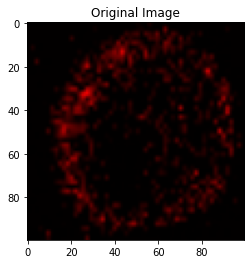

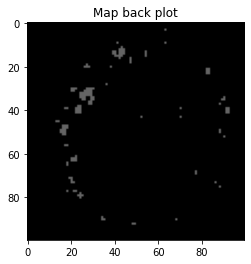

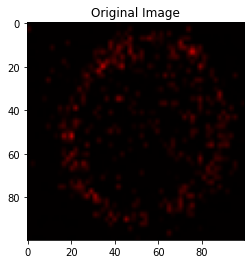

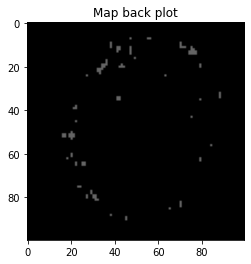

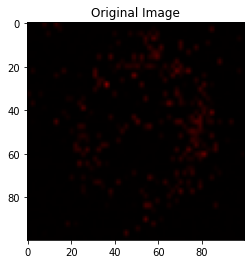

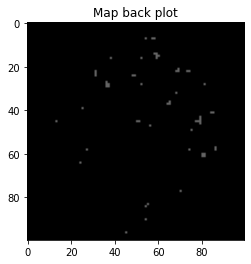

In [ ]:
# plotting the back plot for 3 test images to validate the values of epsilon and min_samples
get_back_plot('/content/drive/MyDrive/image_data/1/134.tif')
get_back_plot('/content/drive/MyDrive/image_data/1/153.tif')
get_back_plot('/content/drive/MyDrive/image_data/1/156.tif')

In [ ]:
# storing the labelled and original image data in corresponding lists by looping through the directory for each image 
labelled_data = []
img_data = []

for i in range(1,5):
  directory = '/content/drive/MyDrive/image_data/' + str(i) + '/'

  if i == 1:
    for j in range(1,161):
      # print(file_name, i, j)
      file_name = directory + str(j) + '.tif'
      img, labels = get_labels_from_dbscan(file_name)
      labelled_data.append(labels)
      img_data.append(img)
      ##### going through every folder was taking so much time, so we decided to use image data from only one condition #####
      ##### and thus commented the following code #####
  # elif i == 2:
  #   for j in range(1,38):
  #     file_name = directory + str(j) + '.tif'
  #     labelled_data.append(get_labels_from_dbscan(file_name))
  # elif i == 3:
  #   for j in range(1,81):
  #     file_name = directory + str(j) + '.tif'
  #     labelled_data.append(get_labels_from_dbscan(file_name))
  # elif i == 4:
  #   for j in range(1,60):
  #     file_name = directory + str(j) + '.tif'
  #     labelled_data.append(get_labels_from_dbscan(file_name))

In [ ]:
labelled_data = np.array(labelled_data)
labelled_data
labelled_data.shape

img_data = np.array(img_data)
img_data.shape

(160, 100, 100)

In [ ]:
np.unique(labelled_data)

array([-1,  0,  1,  2,  3])

In [ ]:
# flattening the image data for each image
labelled_data = labelled_data.reshape(-1,10000)
# assigning each pixel which belongs to a cluster to the value of 1
labelled_data[labelled_data > 0] = 1
# rest background and noise pixels are assigned 0
labelled_data[labelled_data <= 0] = 0

# assigning the final label to every image as either one or zero depending 
# upon the total number of labels are greater than the threshold or not

final_labels = []
threshold = 0
for i in range(160):
  count =np.sum(labelled_data[i,:])
  if count > threshold:
    final_labels.append(1)
  else:
    final_labels.append(0)

final_labels = np.array(final_labels)



np.unique(labelled_data)
final_labels = final_labels.reshape(-1,1)
final_labels.shape

(160, 1)

In [ ]:
np.unique(labelled_data)

array([0, 1])

In [ ]:
final_labels.shape

(160, 1)

In [ ]:
labelled_data.reshape(-1,10000).shape

(160, 10000)

In [ ]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_data, final_labels, test_size=0.2)

y_train.shape

(128, 1)

In [ ]:
img_data.shape

(160, 100, 100)

In [ ]:
# defining the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# training the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
4/4 [==============================] - 2s 283ms/step - loss: 14.8498 - accuracy: 0.4531 - val_loss: 13.9522 - val_accuracy: 0.5625
Epoch 2/100
4/4 [==============================] - 1s 197ms/step - loss: 11.1412 - accuracy: 0.5469 - val_loss: 7.2354 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 161ms/step - loss: 3.1724 - accuracy: 0.6562 - val_loss: 6.5807 - val_accuracy: 0.4688
Epoch 4/100
4/4 [==============================] - 1s 167ms/step - loss: 3.3461 - accuracy: 0.5625 - val_loss: 3.1577 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 1s 161ms/step - loss: 1.4911 - accuracy: 0.7656 - val_loss: 4.9571 - val_accuracy: 0.5312
Epoch 6/100
4/4 [==============================] - 1s 162ms/step - loss: 2.4559 - accuracy: 0.7031 - val_loss: 3.5842 - val_accuracy: 0.5312
Epoch 7/100
4/4 [==============================] - 1s 142ms/step - loss: 0.8197 - accuracy: 0.8281 - val_loss: 2.5213 - val_accuracy: 0.5000
Epoch 8/10

In [ ]:
# evaluating the model on the testing data
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

1/1 [==============================] - 0s 64ms/step - loss: 1.7402 - accuracy: 0.5625
Test accuracy: 0.5625


In [ ]:
def get_prob_of_containing_stress_granule(filename):
  img = plt.imread(filename)
  img = cv2.resize(img, (100, 100))
  gray_img = np.mean(img, axis=2)
  gray_img= gray_img.reshape(1,100,100)
  res = model.predict(gray_img)
  return res

In [ ]:
get_prob_of_containing_stress_granule('/content/drive/MyDrive/image_data/1/125.tif')

1/1 [==============================] - 0s 83ms/step


array([[0.00020857]], dtype=float32)

In [ ]:
get_prob_of_containing_stress_granule('/content/drive/MyDrive/image_data/1/132.tif')

1/1 [==============================] - 0s 48ms/step


array([[1.]], dtype=float32)

1/1 [==============================] - 0s 54ms/step
(10, 1) (10, 100, 100)


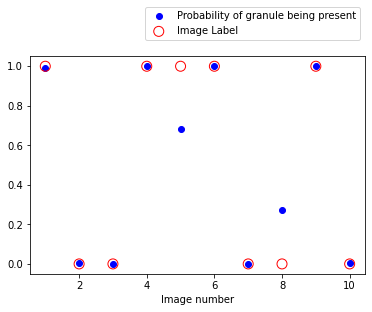

In [ ]:
test_images = []

for i in range(10):
  file_name = '/content/drive/MyDrive/image_data/1/' + str(i+1) + '.tif'
  img = plt.imread(file_name)
  img = cv2.resize(img, (100, 100))
  gray_img = np.mean(img, axis=2)
  test_images.append(gray_img)

test_images = np.array(test_images)

predictions = model.predict(test_images)

print(predictions.shape, test_images.shape)
img_numbers = np.array(list(range(1,11)))
plt.scatter(img_numbers, predictions, label='Probability of granule being present', c='b')
plt.scatter(img_numbers, final_labels[:10], label='Image Label', marker='o', facecolors='none', edgecolors='r', s=100)
plt.xlabel('Image number')
# plt.ylabel('Probability of granule being present')
plt.legend(bbox_to_anchor=(1, 1.25))

In [ ]:
_, rmse = model.evaluate(X_test, y_test)
rmse

1/1 [==============================] - 0s 109ms/step - loss: 1.7402 - accuracy: 0.5625


0.5625

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 1)         10        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 1)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2401)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                153728    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 153,803
Trainable params: 153,803
Non-trainable params: 0
________________________________________________

In [ ]:
# printing the confusion matrix

# finding y_predicted for the test data
y_pred = model.predict(X_test)
y_pred

# classifying y_predicted as zero if probability from sigmoid function at last layer is less than 0.5 and vice-versa
y_pred_final = []
for prob in y_pred:
  if prob < 0.5:
    y_pred_final.append(0)
  else:
    y_pred_final.append(1)

y_pred_final = np.array(y_pred_final)

cm = confusion_matrix(y_test, y_pred_final)
print(cm)

1/1 [==============================] - 0s 104ms/step
[[ 8  6]
 [ 8 10]]
